## Import all modules

In [2]:
import pandas as pd # to start reading csv
import numpy as np
import matplotlib.pyplot as plt #plotting basic
import seaborn as sns
%matplotlib inline

## Reading all the files

In [3]:
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
order_products_train = pd.read_csv("order_products__train.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")

In [4]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


## Opening the Training data

In [5]:
train_orders=orders[orders['eval_set']=='train']
trains=pd.merge(order_products_train, train_orders,how='left', on='order_id')
trains.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,112108,train,4,4,10,9.0
1,1,11109,2,1,112108,train,4,4,10,9.0
2,1,10246,3,0,112108,train,4,4,10,9.0
3,1,49683,4,0,112108,train,4,4,10,9.0
4,1,43633,5,1,112108,train,4,4,10,9.0


In [6]:
prior_orders=orders[orders['eval_set']=='prior']
priors = pd.merge(order_products_prior, prior_orders, on='order_id',how ='right')
priors.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


## Feature Engineering Part I: Product Features

- purchase_count: How many people purchased this product
- reordered_count: How many people reordered this product

In [7]:
priors_product = pd.merge(priors, products, on='product_id')
priors_product.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16
2,120,33120,13,0,23750,prior,11,6,8,10.0,Organic Egg Whites,86,16
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16


In [8]:
priors_product_purchase= priors_product.groupby(["product_id"]).size().reset_index(name ='purchase_count')
priors_product_purchase.head()

,product_id,purchase_count
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


In [9]:
priors_reordered = priors_product[priors_product['reordered'] == 1]
priors_reordered.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16
5,537,33120,2,1,180135,prior,15,2,8,3.0,Organic Egg Whites,86,16
6,582,33120,7,1,193223,prior,6,2,19,10.0,Organic Egg Whites,86,16


In [10]:
priors_product_reordered= priors_reordered.groupby(["product_id"]).size().reset_index(name ='reordered_count')
priors_product_reordered.head()

,product_id,reordered_count
0,1,1136
1,2,12
2,3,203
3,4,147
4,5,9


In [11]:
prods=pd.merge(priors_product_purchase,priors_product_reordered, on='product_id')
prods['prod_reorder_rate']=prods['reordered_count']/prods['purchase_count']
prods.head()

,product_id,purchase_count,reordered_count,prod_reorder_rate
0,1,1852,1136,0.613391
1,2,90,12,0.133333
2,3,277,203,0.732852
3,4,329,147,0.446809
4,5,15,9,0.600000


## Feature Engineering Part 2: User Features

- average number of days the user comes back from shopping
- average size of user cart
- total order per user

In [12]:
avg_reorder_days = prior_orders.groupby(["user_id"])['days_since_prior_order'].aggregate('count').reset_index(name='avg_days_prior_order')
avg_reorder_days.head()

,user_id,avg_days_prior_order
0,1,9
1,2,13
2,3,11
3,4,4
4,5,3


In [13]:
avg_usercart_size = priors_reordered.groupby(["user_id"])['add_to_cart_order'].aggregate('count').reset_index(name='avg_user_cart_size')
avg_usercart_size.head()

,user_id,avg_user_cart_size
0,1,41
1,2,93
2,3,55
3,4,1
4,5,14


In [14]:
total_order_per_user = prior_orders.groupby('user_id').size().reset_index(name='total_order_per_user')
total_order_per_user.head()

,user_id,total_order_per_user
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [15]:
users= pd.merge(avg_reorder_days,avg_usercart_size)
users_fin=pd.merge(users,total_order_per_user)
users_fin.head()

,user_id,avg_days_prior_order,avg_user_cart_size,total_order_per_user
0,1,9,41,10
1,2,13,93,14
2,3,11,55,12
3,4,4,1,5
4,5,3,14,4


# Feature Engineering Part 3: Product User features

- how many times this specific user buy this product
- reorder rate of this product by the user: reorder rate = product reordered by this customer/number of order by this customer

In [16]:
priors_product_purchase_spec= priors_product.groupby(["user_id","product_id"]).size().reset_index(name ='purchase_count_spec')
priors_product_purchase_spec['userprod_id']=priors_product_purchase_spec['product_id'] + priors_product_purchase_spec['user_id'] *100000
priors_product_purchase_spec.head(10)

,user_id,product_id,purchase_count_spec,userprod_id
0,1,196,10,100196
1,1,10258,9,110258
2,1,10326,1,110326
3,1,12427,10,112427
4,1,13032,3,113032
5,1,13176,2,113176
6,1,14084,1,114084
7,1,17122,1,117122
8,1,25133,8,125133
9,1,26088,2,126088


In [17]:
#mistake here to just use priors_reordered for reorder =1 which makes all data reorder =1 only
priors_product_reordered_spec= priors_reordered.groupby(["user_id","product_id"]).size().reset_index(name ='reordered_count_spec')
priors_product_reordered_spec['userprod_id']=priors_product_reordered_spec['product_id'] + priors_product_reordered_spec['user_id'] *100000
priors_product_reordered_spec.head(10)

,user_id,product_id,reordered_count_spec,userprod_id
0,1,196,9,100196
1,1,10258,8,110258
2,1,12427,9,112427
3,1,13032,2,113032
4,1,13176,1,113176
5,1,25133,7,125133
6,1,26088,1,126088
7,1,26405,1,126405
8,1,46149,2,146149
9,1,49235,1,149235


In [18]:
prods_user =pd.merge(priors_product_purchase_spec,priors_product_reordered_spec, on="userprod_id",how="outer")
prods_user['reorder_ratio']=prods_user['reordered_count_spec']/prods_user['purchase_count_spec']
prods_user.head()

,user_id_x,product_id_x,purchase_count_spec,userprod_id,user_id_y,product_id_y,reordered_count_spec,reorder_ratio
0,1,196,10,100196,1.0,196.0,9.0,0.900000
1,1,10258,9,110258,1.0,10258.0,8.0,0.888889
2,1,10326,1,110326,NaN,NaN,NaN,NaN
3,1,12427,10,112427,1.0,12427.0,9.0,0.900000
4,1,13032,3,113032,1.0,13032.0,2.0,0.666667


In [19]:
columns=['user_id_x','product_id_x','user_id_y','product_id_y']
prods_user.drop(columns, inplace=True, axis=1)
#prods_user.rename(columns={'user_id_x': 'user_id', 'product_id_x': 'product_id'}, inplace=True)

In [20]:
prods_user=prods_user.fillna(0)
prods_user.head()

,purchase_count_spec,userprod_id,reordered_count_spec,reorder_ratio
0,10,100196,9.0,0.900000
1,9,110258,8.0,0.888889
2,1,110326,0.0,0.000000
3,10,112427,9.0,0.900000
4,3,113032,2.0,0.666667


# Merging All prior data to train data
- merging train data with F.E 1, product id
- merging the product of the merged data with F.E 2, user id
- merging the product of the merged data with F.E 3, product id, user id

- Note that we should have 8-12 features up until here

In [21]:
trains_fe= pd.merge(trains, prods, on='product_id')
trains_fe.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,purchase_count,reordered_count,prod_reorder_rate
0,1,49302,1,1,112108,train,4,4,10,9.0,163,101,0.619632
1,816049,49302,7,1,47901,train,14,4,6,16.0,163,101,0.619632
2,1242203,49302,1,1,2993,train,15,0,7,7.0,163,101,0.619632
3,1383349,49302,11,1,41425,train,4,3,8,14.0,163,101,0.619632
4,1787378,49302,8,0,187205,train,5,4,14,30.0,163,101,0.619632


In [22]:
trains_fe1=pd.merge(trains_fe,users_fin)
trains_fe1.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,purchase_count,reordered_count,prod_reorder_rate,avg_days_prior_order,avg_user_cart_size,total_order_per_user
0,1,49302,1,1,112108,train,4,4,10,9.0,163,101,0.619632,2,9,3
1,1,11109,2,1,112108,train,4,4,10,9.0,4472,3192,0.713775,2,9,3
2,1,10246,3,0,112108,train,4,4,10,9.0,23826,12498,0.524553,2,9,3
3,1,49683,4,0,112108,train,4,4,10,9.0,97315,67313,0.691702,2,9,3
4,1,43633,5,1,112108,train,4,4,10,9.0,653,312,0.477795,2,9,3


In [23]:
#trains_fe2=pd.merge(trains_fe1,prods_user, on=['userprod_id'])
#trains_fe2.head()

# Training and Testing Section

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV


/Users/Gary/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Gary/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Deciding the Predictor and Target Variables

In [25]:
#features
trains_fe2_x= trains_fe1.drop(['days_since_prior_order','add_to_cart_order','reordered','eval_set'], axis=1)
trains_fe2_x.head() #12 features as the predictor variables

,order_id,product_id,user_id,order_number,order_dow,order_hour_of_day,purchase_count,reordered_count,prod_reorder_rate,avg_days_prior_order,avg_user_cart_size,total_order_per_user
0,1,49302,112108,4,4,10,163,101,0.619632,2,9,3
1,1,11109,112108,4,4,10,4472,3192,0.713775,2,9,3
2,1,10246,112108,4,4,10,23826,12498,0.524553,2,9,3
3,1,49683,112108,4,4,10,97315,67313,0.691702,2,9,3
4,1,43633,112108,4,4,10,653,312,0.477795,2,9,3


In [26]:
#target
trains_fe2_y= trains_fe1[['reordered']]
trains_fe2_y.head()

,reordered
0,1
1,1
2,0
3,0
4,1


In [27]:
# before train test split, split into x_train and y_train
X_train, X_test, y_train, y_test = train_test_split(trains_fe2_x, trains_fe2_y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(830500, 12)
(830500, 1)
(207626, 12)
(207626, 1)


## Applying Logistic Regressor

In [28]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

/Users/Gary/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
y_pred_lgr =logreg.predict(X_test)
y_train_pred_lgr=logreg.predict(X_train)
print("Accuracy of logistic regression classifier on on test set: {:0.5f}".format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on on test set: 0.64805


Next, cross validation is run to avoid overfitting while producing a prediction on each feature. Let's apply a 10-fold to train out logistic regression model

In [30]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold =model_selection.KFold(n_splits=10, random_state=7)
modelCV =LogisticRegression()
scoring ='accuracy'
results =model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring='accuracy')
print ("10-fold cross validation average accuracy: %.3f" %(results.mean()))

10-fold cross validation average accuracy: 0.653


In [31]:
#training_accuracy = model.score(y_train, y_train_pred)
#test_accuracy = model.score(y_test, y_pred)
#print("Accuracy on training data: {:0.5f}".format(training_accuracy))
#print("Accuracy on test data:     {:0.5f}".format(test_accuracy))

If the average accuracyremains very close to the model accuracy, we can conclude the model generalizes well.

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_lgr))

             precision    recall  f1-score   support

          0       0.65      0.25      0.36     82313
          1       0.65      0.91      0.76    125313

avg / total       0.65      0.65      0.60    207626



In [33]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_lgr)
print(confusion_matrix)

[[ 20441  61872]
 [ 11202 114111]]


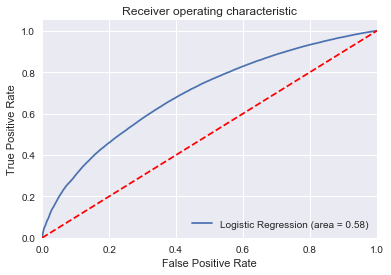

In [34]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [35]:
# Compute and print R^2 and RMSE
from sklearn.metrics import mean_squared_error
print("R^2: {}".format(logreg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred_lgr))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.648049858881
Root Mean Squared Error: 0.593253858916


In [36]:
#computing the f1 score
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_lgr, average='macro')  

0.55811012016561201

In [37]:
roc_auc_score(y_test, y_pred_lgr)

0.57947021106708718

## Trying other models
- Decision trees
- LightGBM Models
- Random Forest
- SVM


## Decision Trees

In [38]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [39]:
y_pred_clf =clf.predict(X_test)
y_train_pred_clf=clf.predict(X_train)
print("Accuracy of logistic regression classifier on on test set: {:0.5f}".format(clf.score(X_test, y_test)))

Accuracy of logistic regression classifier on on test set: 0.68593


In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_clf))

             precision    recall  f1-score   support

          0       0.63      0.52      0.57     82313
          1       0.72      0.80      0.75    125313

avg / total       0.68      0.69      0.68    207626



In [41]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_clf)
print(confusion_matrix)

[[42714 39599]
 [25611 99702]]


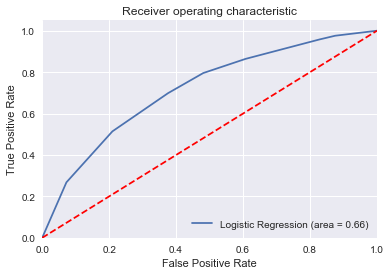

In [42]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [43]:
roc_auc_score(y_test, y_pred_clf)

0.65727271756152239

## Random Forest Classifier

In [44]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 10, random_state = 42)
# Train the model on training data
rf.fit(X_train,y_train)

/Users/Gary/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [45]:
# Use the forest's predict method on the test data
y_pred_rf = rf.predict(X_test)
y_train_pred_rf=rf.predict(X_train)
print("Accuracy of logistic regression classifier on on test set: {:0.5f}".format(rf.score(X_test, y_test)))

Accuracy of logistic regression classifier on on test set: 0.66443


In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_rf))

             precision    recall  f1-score   support

          0       0.57      0.60      0.58     82313
          1       0.73      0.71      0.72    125313

avg / total       0.67      0.66      0.67    207626



In [47]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_rf)
print(confusion_matrix)

[[49047 33266]
 [36408 88905]]


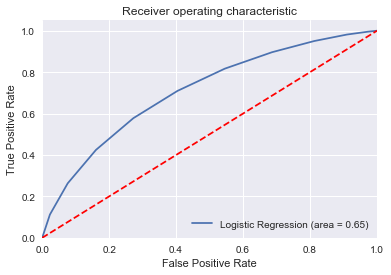

In [48]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [49]:
roc_auc_score(y_test, y_pred_rf)

0.65266160481537994

Similarly, accuracy shows low gain of data from the chosen criterion, the data can't handle mix of binary and continuous to give accuracy score.

In [51]:
# Checking features importance
# list of x locations for plotting
#x_values = list(range(len(trains_fe2_x)))
# Make a bar chart
#plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
#plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
#plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

## LightGBM Model


In [52]:
import lightgbm as lgb
mdl =lgb.LGBMClassifier(boosting_type ='gbdt',objective ='binary', num_leaves =50)
mdl.fit(X_train,y_train)

/Users/Gary/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Gary/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

In [53]:
# Use the forest's predict method on the test data
y_pred_mdl = mdl.predict(X_test)
y_train_pred_mdl=mdl.predict(X_train)
print("Accuracy of logistic regression classifier on on test set: {:0.5f}".format(mdl.score(X_test, y_test)))

Accuracy of logistic regression classifier on on test set: 0.69759


In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_mdl))

             precision    recall  f1-score   support

          0       0.65      0.52      0.58     82313
          1       0.72      0.82      0.77    125313

avg / total       0.69      0.70      0.69    207626



In [55]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_mdl)
print(confusion_matrix)

[[ 42558  39755]
 [ 23033 102280]]


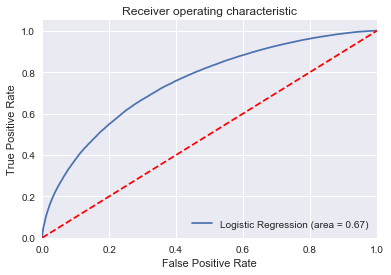

In [56]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, mdl.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, mdl.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [57]:
roc_auc_score(y_test, y_pred_mdl)

0.66661135836410379

In [58]:
X_train.head()

,order_id,product_id,user_id,order_number,order_dow,order_hour_of_day,purchase_count,reordered_count,prod_reorder_rate,avg_days_prior_order,avg_user_cart_size,total_order_per_user
425223,2225684,48364,118793,44,0,14,19501,10338,0.530127,42,164,43
662476,1227167,39190,144948,9,1,14,10972,6294,0.573642,7,7,8
751228,1702165,26100,136157,29,5,11,394,219,0.555838,27,202,28
748606,1412271,8021,109353,7,5,14,27864,16472,0.591157,5,33,6
450013,472698,4302,158874,14,2,20,2772,1138,0.410534,12,168,13


In [69]:
X_reduced =X_train[X_train.columns[6:]]
X_reduced.info()
X_reduced.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 830500 entries, 425223 to 631587
Data columns (total 6 columns):
purchase_count          830500 non-null int64
reordered_count         830500 non-null int64
prod_reorder_rate       830500 non-null float64
avg_days_prior_order    830500 non-null int64
avg_user_cart_size      830500 non-null int64
total_order_per_user    830500 non-null int64
dtypes: float64(1), int64(5)
memory usage: 44.4 MB


,purchase_count,reordered_count,prod_reorder_rate,avg_days_prior_order,avg_user_cart_size,total_order_per_user
425223,19501,10338,0.530127,42,164,43
662476,10972,6294,0.573642,7,7,8
751228,394,219,0.555838,27,202,28
748606,27864,16472,0.591157,5,33,6
450013,2772,1138,0.410534,12,168,13


In [60]:
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
#,'max_depth':[4,6,8,10]
param_grid = {'learning_rate': [0.05,0.1],'num_leaves': [40,60,80]}

In [62]:
# Instantiate a lgb classifier: lgb
lgb_mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary')
# Instantiate the GridSearchCV object: logreg_cv
lgb_cv = GridSearchCV(lgb_mdl, param_grid,verbose=1, cv=5, n_jobs=-1)

In [ ]:
# Fit it to the data
lgb_cv.fit(X_reduced.values(,y_train.reshape(204))


# Print the tuned parameters and score
print(lgb_cv.best_params_)
print(lgb_cv.best_score_)

In [76]:
y_train.values()

TypeError: 'numpy.ndarray' object is not callable

## Aplying SMOTE to see balanced dataset

https://elitedatascience.com/imbalanced-classes

In [77]:
pd.crosstab(
    pd.Series(y_test,name='Actual'),
    pd.Series(y_pred_lgr,name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
"(r, e, o, r, d, e, r, e, d)",31643,175983,207626
All,31643,175983,207626


Since the values of 1 in reorder ratio is more than 0, there is a down sampling imbalanced dataset existing in the results that may affect obtaining the right reorder ratio, so to reduce the majority, SMOTE is applied.

In [89]:
X_train.head()

,order_id,product_id,user_id,order_number,order_dow,order_hour_of_day,purchase_count,reordered_count,prod_reorder_rate,avg_days_prior_order,avg_user_cart_size,total_order_per_user
425223,2225684,48364,118793,44,0,14,19501,10338,0.530127,42,164,43
662476,1227167,39190,144948,9,1,14,10972,6294,0.573642,7,7,8
751228,1702165,26100,136157,29,5,11,394,219,0.555838,27,202,28
748606,1412271,8021,109353,7,5,14,27864,16472,0.591157,5,33,6
450013,472698,4302,158874,14,2,20,2772,1138,0.410534,12,168,13


In [90]:
X_train['reorders']= y_pred_mdl

/Users/Gary/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [91]:
X_train.head()

,order_id,product_id,user_id,order_number,order_dow,order_hour_of_day,purchase_count,reordered_count,prod_reorder_rate,avg_days_prior_order,avg_user_cart_size,total_order_per_user,reorders
425223,2225684,48364,118793,44,0,14,19501,10338,0.530127,42,164,43,1
662476,1227167,39190,144948,9,1,14,10972,6294,0.573642,7,7,8,1
751228,1702165,26100,136157,29,5,11,394,219,0.555838,27,202,28,1
748606,1412271,8021,109353,7,5,14,27864,16472,0.591157,5,33,6,1
450013,472698,4302,158874,14,2,20,2772,1138,0.410534,12,168,13,0


In [ ]:
y_pred_mdl.head()